# 1.24c5: Variance-State Correlation - Does Gradient Uncertainty Drive Quantization?

**Purpose:** Test if Adam variance (second moment) directly correlates with classical → quantum → frozen transitions.

## The Discovery from 1.24c4

Momentum showed **hysteresis**: it acts like a thermostat setting, not room temperature.
- Momentum drops → system *gradually* cools → phase transitions lag behind
- Momentum is the **forcing function**, but the system has thermal mass

## The Variance Hypothesis

Adam's variance term (`exp_avg_sq`) tracks the *scale* of gradient updates:

$$\Delta w \propto \frac{m_t}{\sqrt{v_t} + \epsilon}$$

Where:
- $m_t$ = momentum (first moment)
- $v_t$ = variance (second moment)

**Physical interpretation:**
- **High variance** → large denominator → small update steps → system is *hot* (chaotic, noisy)
- **Low variance** → small denominator → optimizer confident → system is *cool* (precise, deterministic)
- **Variance → 0** → updates so small they can't overcome quantization → freeze

**Hypothesis:** Variance IS the room temperature, not just the thermostat.
- High variance → classical motion
- Variance drops → quantum transition (near lattice threshold)
- Variance minimum → peak freeze (early frost)
- Variance stable/low → frozen state dominates

## What We'll Do

1. **Load state fractions** (classical, quantum, frozen) from 1.24c
2. **Compute variance norms** from Adam's `exp_avg_sq`
3. **Plot overlays** to see if variance tracks state transitions tightly
4. **Correlation analysis** (Pearson r) - does variance beat momentum?
5. **Timing analysis** - does variance minimum match frozen maximum?
6. **Compare to momentum** - which is the better predictor?

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Key windows (from 1.24c2)
SPIKE_WINDOW = (0, 50)
DIP_WINDOW = (200, 250)
RECOVERY_WINDOW = (250, 450)
FREEZE_WINDOW = (450, 600)

# ULP detection parameters (from 1.24c)
QUANTIZED_THRESHOLD = 0.1  # Consider displacement quantized if within 0.1 of integer ULP
QUANTUM_FRACTION = 0.7     # >70% dimensions quantized = quantum state
CLASSICAL_MULTIPLE = 10.0  # Displacement > 10× mean ULP = classical

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
momentum_W = data['momentum_W'][0].float()  # (1001, 10000, 64)
variance_W = data['variance_W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W: {tuple(W.shape)}")
print(f"Momentum: {tuple(momentum_W.shape)}")
print(f"Variance: {tuple(variance_W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...

W: (1001, 10000, 64)
Momentum: (1001, 10000, 64)
Variance: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Compute Variance Norms

In [5]:
print("Computing variance norms...\n")

# Extract dead token variance (exp_avg_sq from Adam)
variance_dead = variance_W[:, dead_mask, :]  # (1001, 3699, 64)

# Compute per-token variance norms (L2), then mean across tokens
variance_norms = torch.norm(variance_dead, dim=2).mean(dim=1)  # (1001,)

# Also compute sqrt(variance) norms - this appears in denominator of Adam update
sqrt_variance_norms = torch.sqrt(variance_dead).norm(dim=2).mean(dim=1)  # (1001,)

print(f"Variance norms shape: {tuple(variance_norms.shape)}")
print(f"Range: {variance_norms.min():.6e} to {variance_norms.max():.6e}")
print(f"\nSqrt(variance) norms shape: {tuple(sqrt_variance_norms.shape)}")
print(f"Range: {sqrt_variance_norms.min():.6e} to {sqrt_variance_norms.max():.6e}")
print(f"\n✓ Variance computed")

Computing variance norms...

Variance norms shape: (1001,)
Range: 0.000000e+00 to 1.241778e-09

Sqrt(variance) norms shape: (1001,)
Range: 0.000000e+00 to 9.428301e-05

✓ Variance computed


## Compute Momentum Norms (for comparison)

In [6]:
print("Computing momentum norms for comparison...\n")

momentum_dead = momentum_W[:, dead_mask, :]  # (1001, 3699, 64)
momentum_norms = torch.norm(momentum_dead, dim=2).mean(dim=1)  # (1001,)

print(f"Momentum norms shape: {tuple(momentum_norms.shape)}")
print(f"Range: {momentum_norms.min():.6e} to {momentum_norms.max():.6e}")
print(f"\n✓ Momentum computed")

Computing momentum norms for comparison...

Momentum norms shape: (1001,)
Range: 0.000000e+00 to 4.808435e-04

✓ Momentum computed


## Compute State Fractions (Classical, Quantum, Frozen)

Replicate the ULP-based classification from 1.24c.

In [7]:
print("Computing state fractions...\n")

# Extract dead tokens only
W_dead = W[:, dead_mask, :]  # (1001, 3699, 64)
n_dead = W_dead.shape[1]
n_steps = W_dead.shape[0]

# Compute displacements
delta_W = W_dead[1:] - W_dead[:-1]  # (1000, 3699, 64)

# Compute per-element ULPs using frexp
_, exponents = torch.frexp(W_dead[:-1].abs())  # (1000, 3699, 64)
ulps = 2.0 ** (exponents - 7)  # bfloat16 has 7 mantissa bits

# Normalize displacements by ULP
normalized_delta = delta_W / (ulps + 1e-10)

# Check if displacement is integer multiple of ULP
rounded = torch.round(normalized_delta)
is_quantized = torch.abs(normalized_delta - rounded) < QUANTIZED_THRESHOLD  # (1000, 3699, 64)

# Per-token metrics
quantized_fraction = is_quantized.float().mean(dim=2)  # (1000, 3699) - fraction of dims quantized
displacement_norm = torch.norm(delta_W, dim=2)  # (1000, 3699)
mean_ulp = ulps.mean(dim=2)  # (1000, 3699)

# Classify each token at each step
is_frozen = (displacement_norm == 0)
is_quantum = (~is_frozen) & (quantized_fraction > QUANTUM_FRACTION) & (displacement_norm < CLASSICAL_MULTIPLE * mean_ulp)
is_classical = (~is_frozen) & (~is_quantum)

# Compute fractions across all dead tokens
frozen_frac = is_frozen.float().mean(dim=1)  # (1000,)
quantum_frac = is_quantum.float().mean(dim=1)  # (1000,)
classical_frac = is_classical.float().mean(dim=1)  # (1000,)

print(f"State fractions shape: {tuple(classical_frac.shape)}")
print(f"Classical range: {classical_frac.min():.3f} to {classical_frac.max():.3f}")
print(f"Quantum range: {quantum_frac.min():.3f} to {quantum_frac.max():.3f}")
print(f"Frozen range: {frozen_frac.min():.3f} to {frozen_frac.max():.3f}")
print(f"\n✓ State fractions computed")

Computing state fractions...

State fractions shape: (1000,)
Classical range: 0.000 to 1.000
Quantum range: 0.000 to 1.000
Frozen range: 0.000 to 1.000

✓ State fractions computed


## Visualization 1: Variance vs State Fractions Overlay

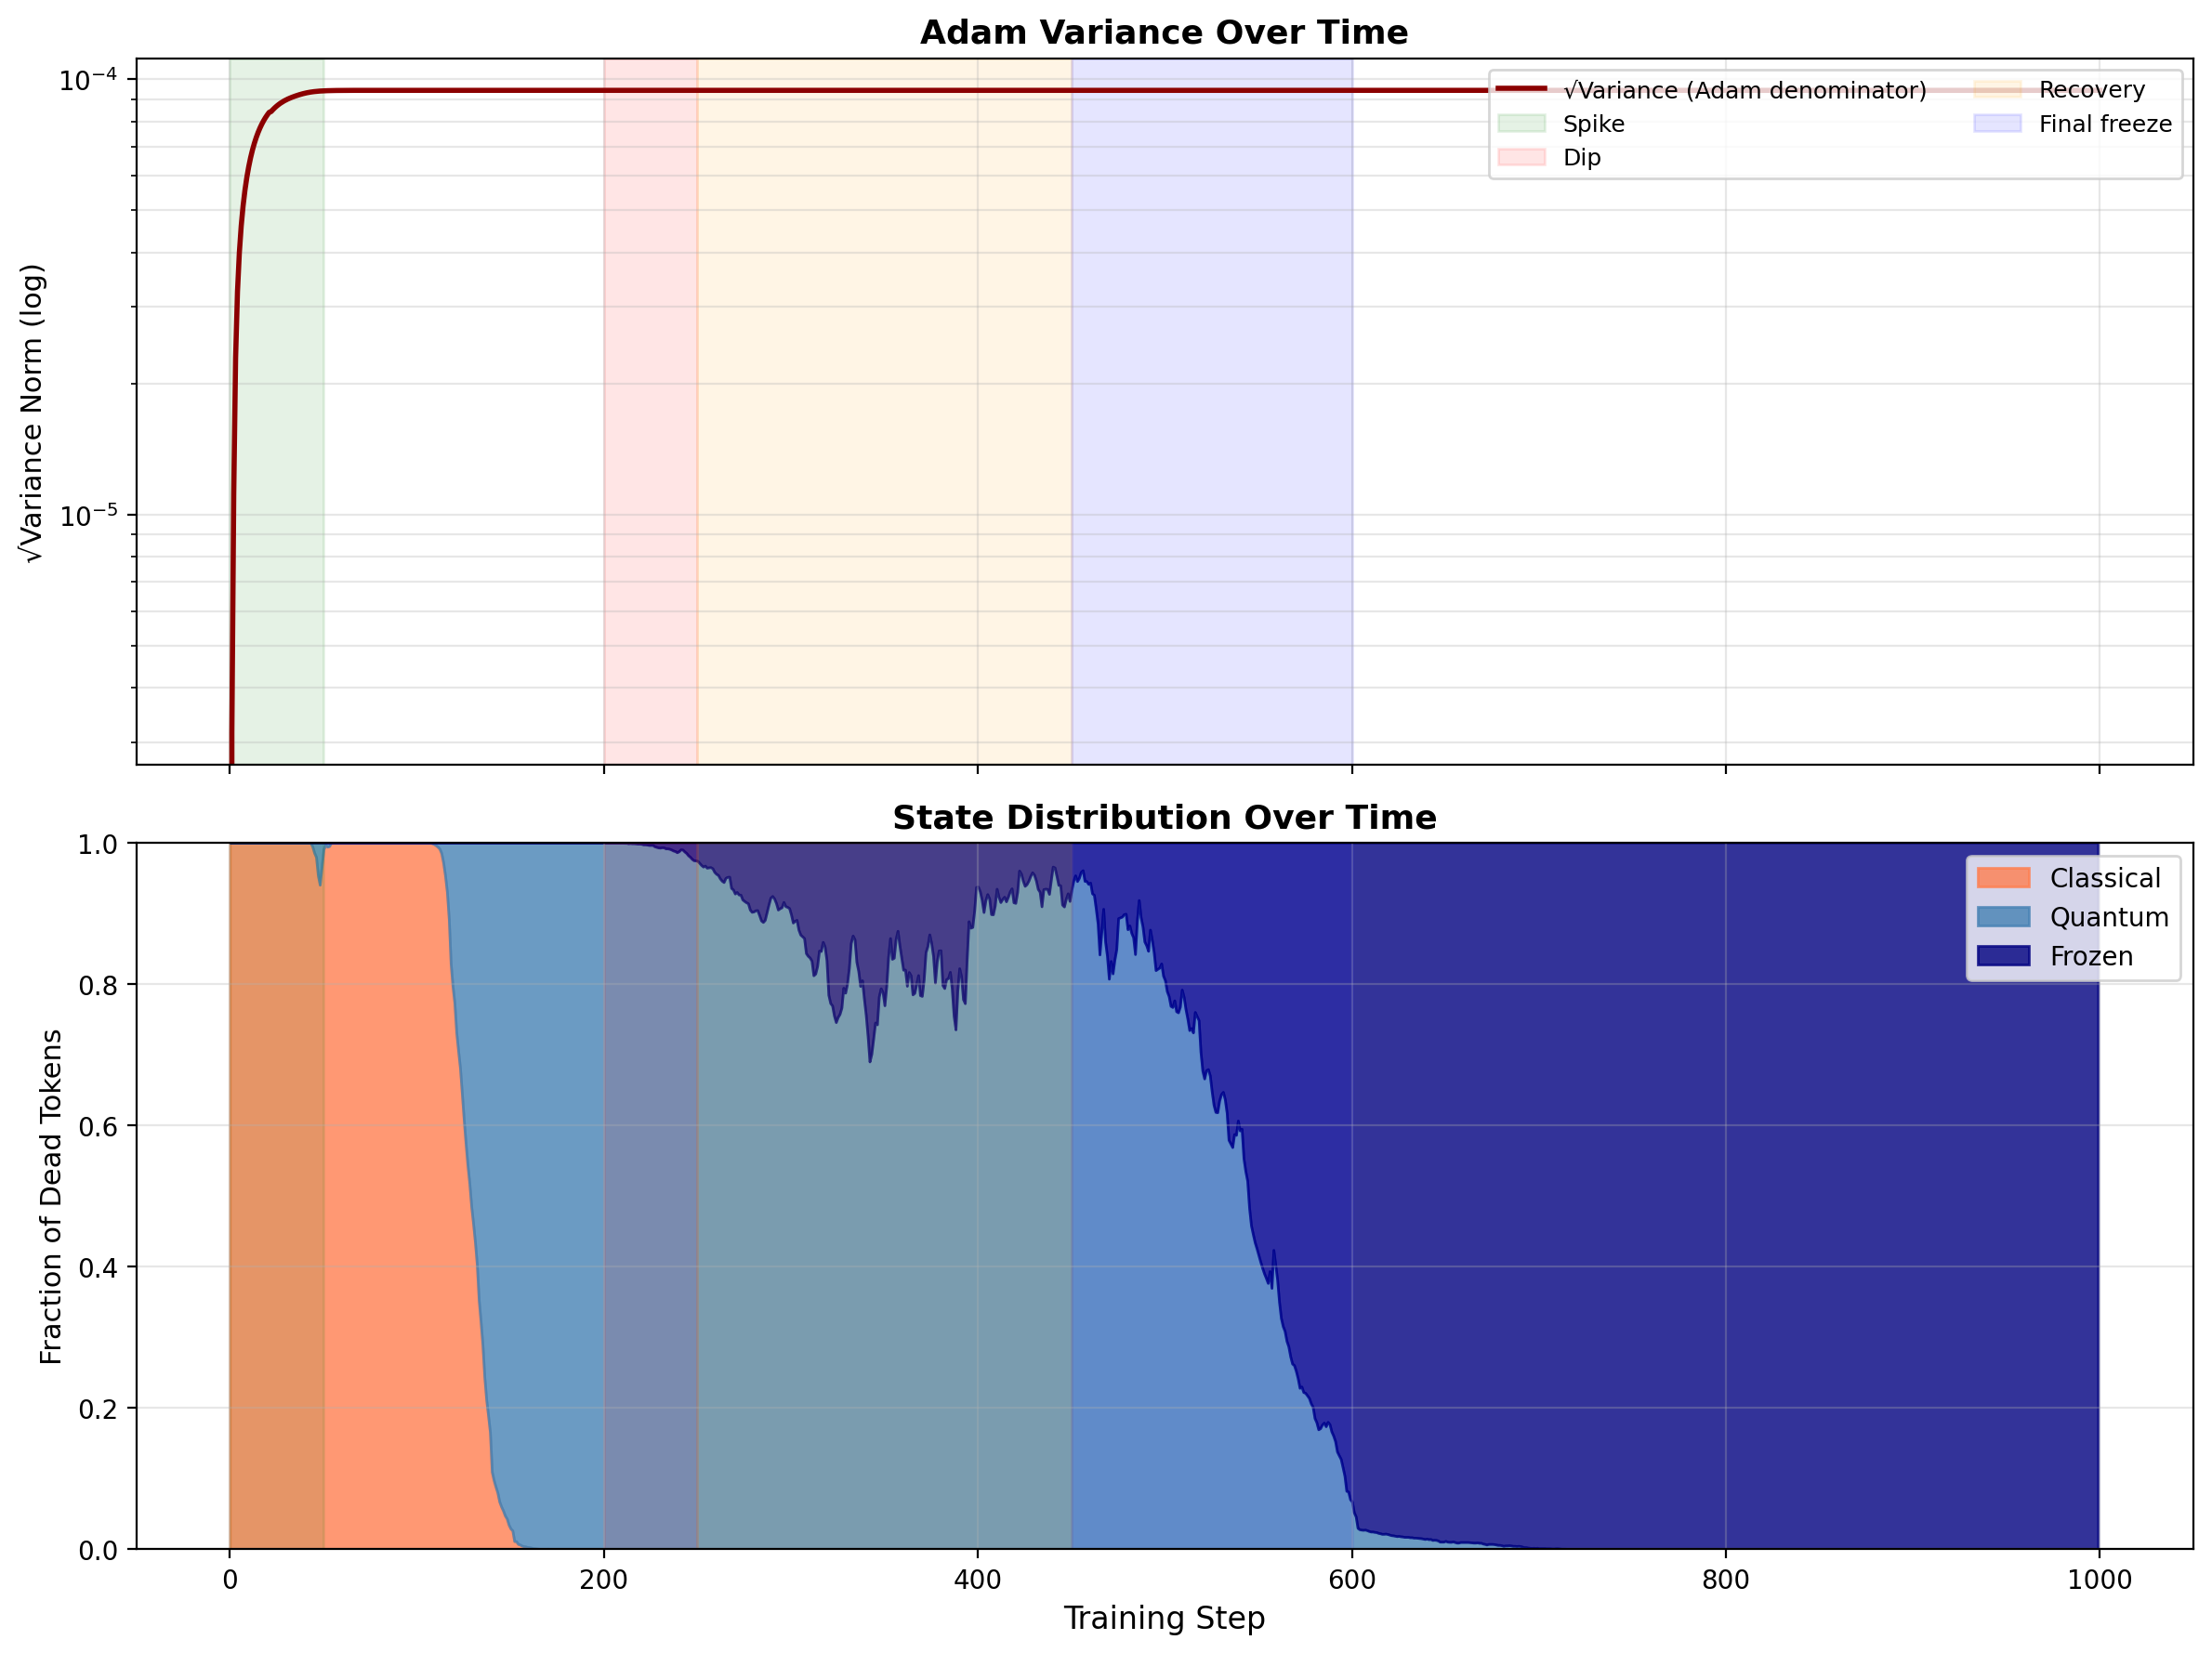


Interpretation: Does variance track state transitions tightly?
  If variance drops → classical→quantum transition happens immediately
  If variance minimum → frozen maximum happens simultaneously
  Then variance IS the room temperature (not just thermostat)


In [8]:
# Two-panel plot: variance + state fractions stacked area
fig, axes = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI, sharex=True)

# Panel 1: Variance (sqrt) over time - this appears in Adam denominator
ax1 = axes[0]
ax1.semilogy(sqrt_variance_norms.numpy(), linewidth=2, color='darkred', label='√Variance (Adam denominator)')
ax1.axvspan(*SPIKE_WINDOW, alpha=0.1, color='green', label='Spike')
ax1.axvspan(*DIP_WINDOW, alpha=0.1, color='red', label='Dip')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange', label='Recovery')
ax1.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue', label='Final freeze')
ax1.set_ylabel('√Variance Norm (log)', fontsize=11)
ax1.set_title('Adam Variance Over Time', fontweight='bold', fontsize=13)
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: State fractions (stacked area)
ax2 = axes[1]
t = np.arange(len(classical_frac))
ax2.fill_between(t, 0, classical_frac.numpy(), label='Classical', color='coral', alpha=0.8)
ax2.fill_between(t, classical_frac.numpy(), 
                 (classical_frac + quantum_frac).numpy(), 
                 label='Quantum', color='steelblue', alpha=0.8)
ax2.fill_between(t, (classical_frac + quantum_frac).numpy(), 1.0,
                 label='Frozen', color='navy', alpha=0.8)
ax2.axvspan(*SPIKE_WINDOW, alpha=0.1, color='green')
ax2.axvspan(*DIP_WINDOW, alpha=0.1, color='red')
ax2.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange')
ax2.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue')
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Fraction of Dead Tokens', fontsize=11)
ax2.set_title('State Distribution Over Time', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: Does variance track state transitions tightly?")
print("  If variance drops → classical→quantum transition happens immediately")
print("  If variance minimum → frozen maximum happens simultaneously")
print("  Then variance IS the room temperature (not just thermostat)")

## Visualization 2: Direct Comparison - Variance vs Frozen Fraction

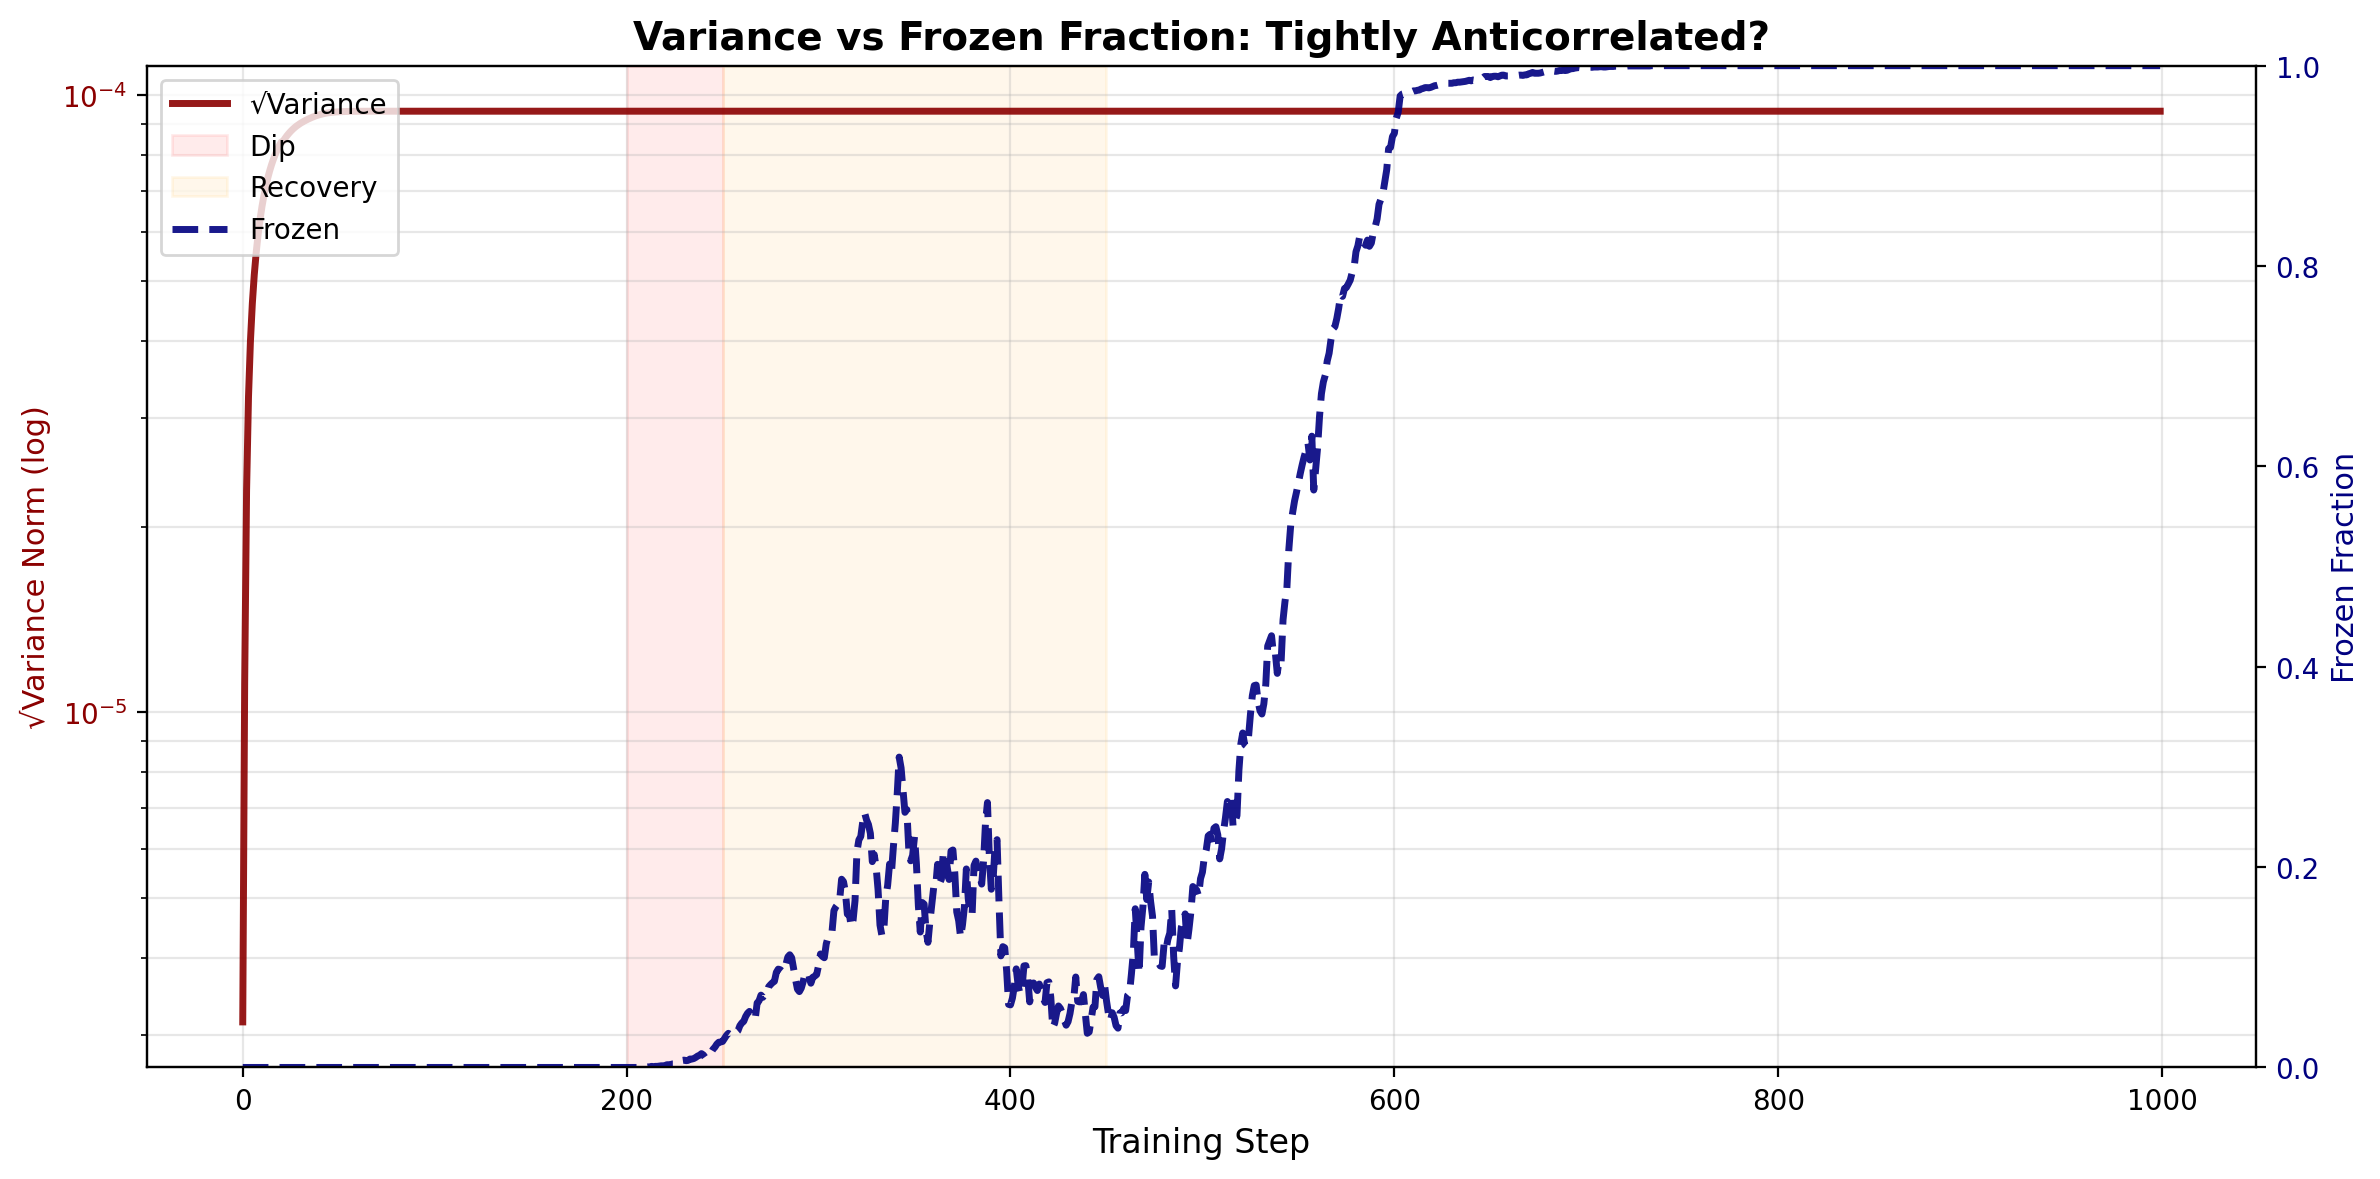


Hypothesis: If frozen fraction peaks when variance bottoms out,
            variance is the ACTUAL temperature (momentum was just thermostat).


In [9]:
# Dual-axis plot: variance and frozen fraction
fig, ax1 = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Left axis: Variance (log scale)
color = 'darkred'
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('√Variance Norm (log)', color=color, fontsize=11)
ax1.semilogy(sqrt_variance_norms[1:].numpy(), linewidth=2.5, color=color, alpha=0.9, label='√Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3, which='both')

# Right axis: Frozen fraction (linear scale)
ax2 = ax1.twinx()
color = 'navy'
ax2.set_ylabel('Frozen Fraction', color=color, fontsize=11)
ax2.plot(frozen_frac.numpy(), linewidth=2.5, color=color, alpha=0.9, label='Frozen', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])

# Shade key windows
ax1.axvspan(*DIP_WINDOW, alpha=0.08, color='red', zorder=-1, label='Dip')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.08, color='orange', zorder=-1, label='Recovery')

ax1.set_title('Variance vs Frozen Fraction: Tightly Anticorrelated?', fontsize=14, fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("\nHypothesis: If frozen fraction peaks when variance bottoms out,")
print("            variance is the ACTUAL temperature (momentum was just thermostat).")

## Visualization 3: Three-Way Comparison - Momentum vs Variance vs Frozen

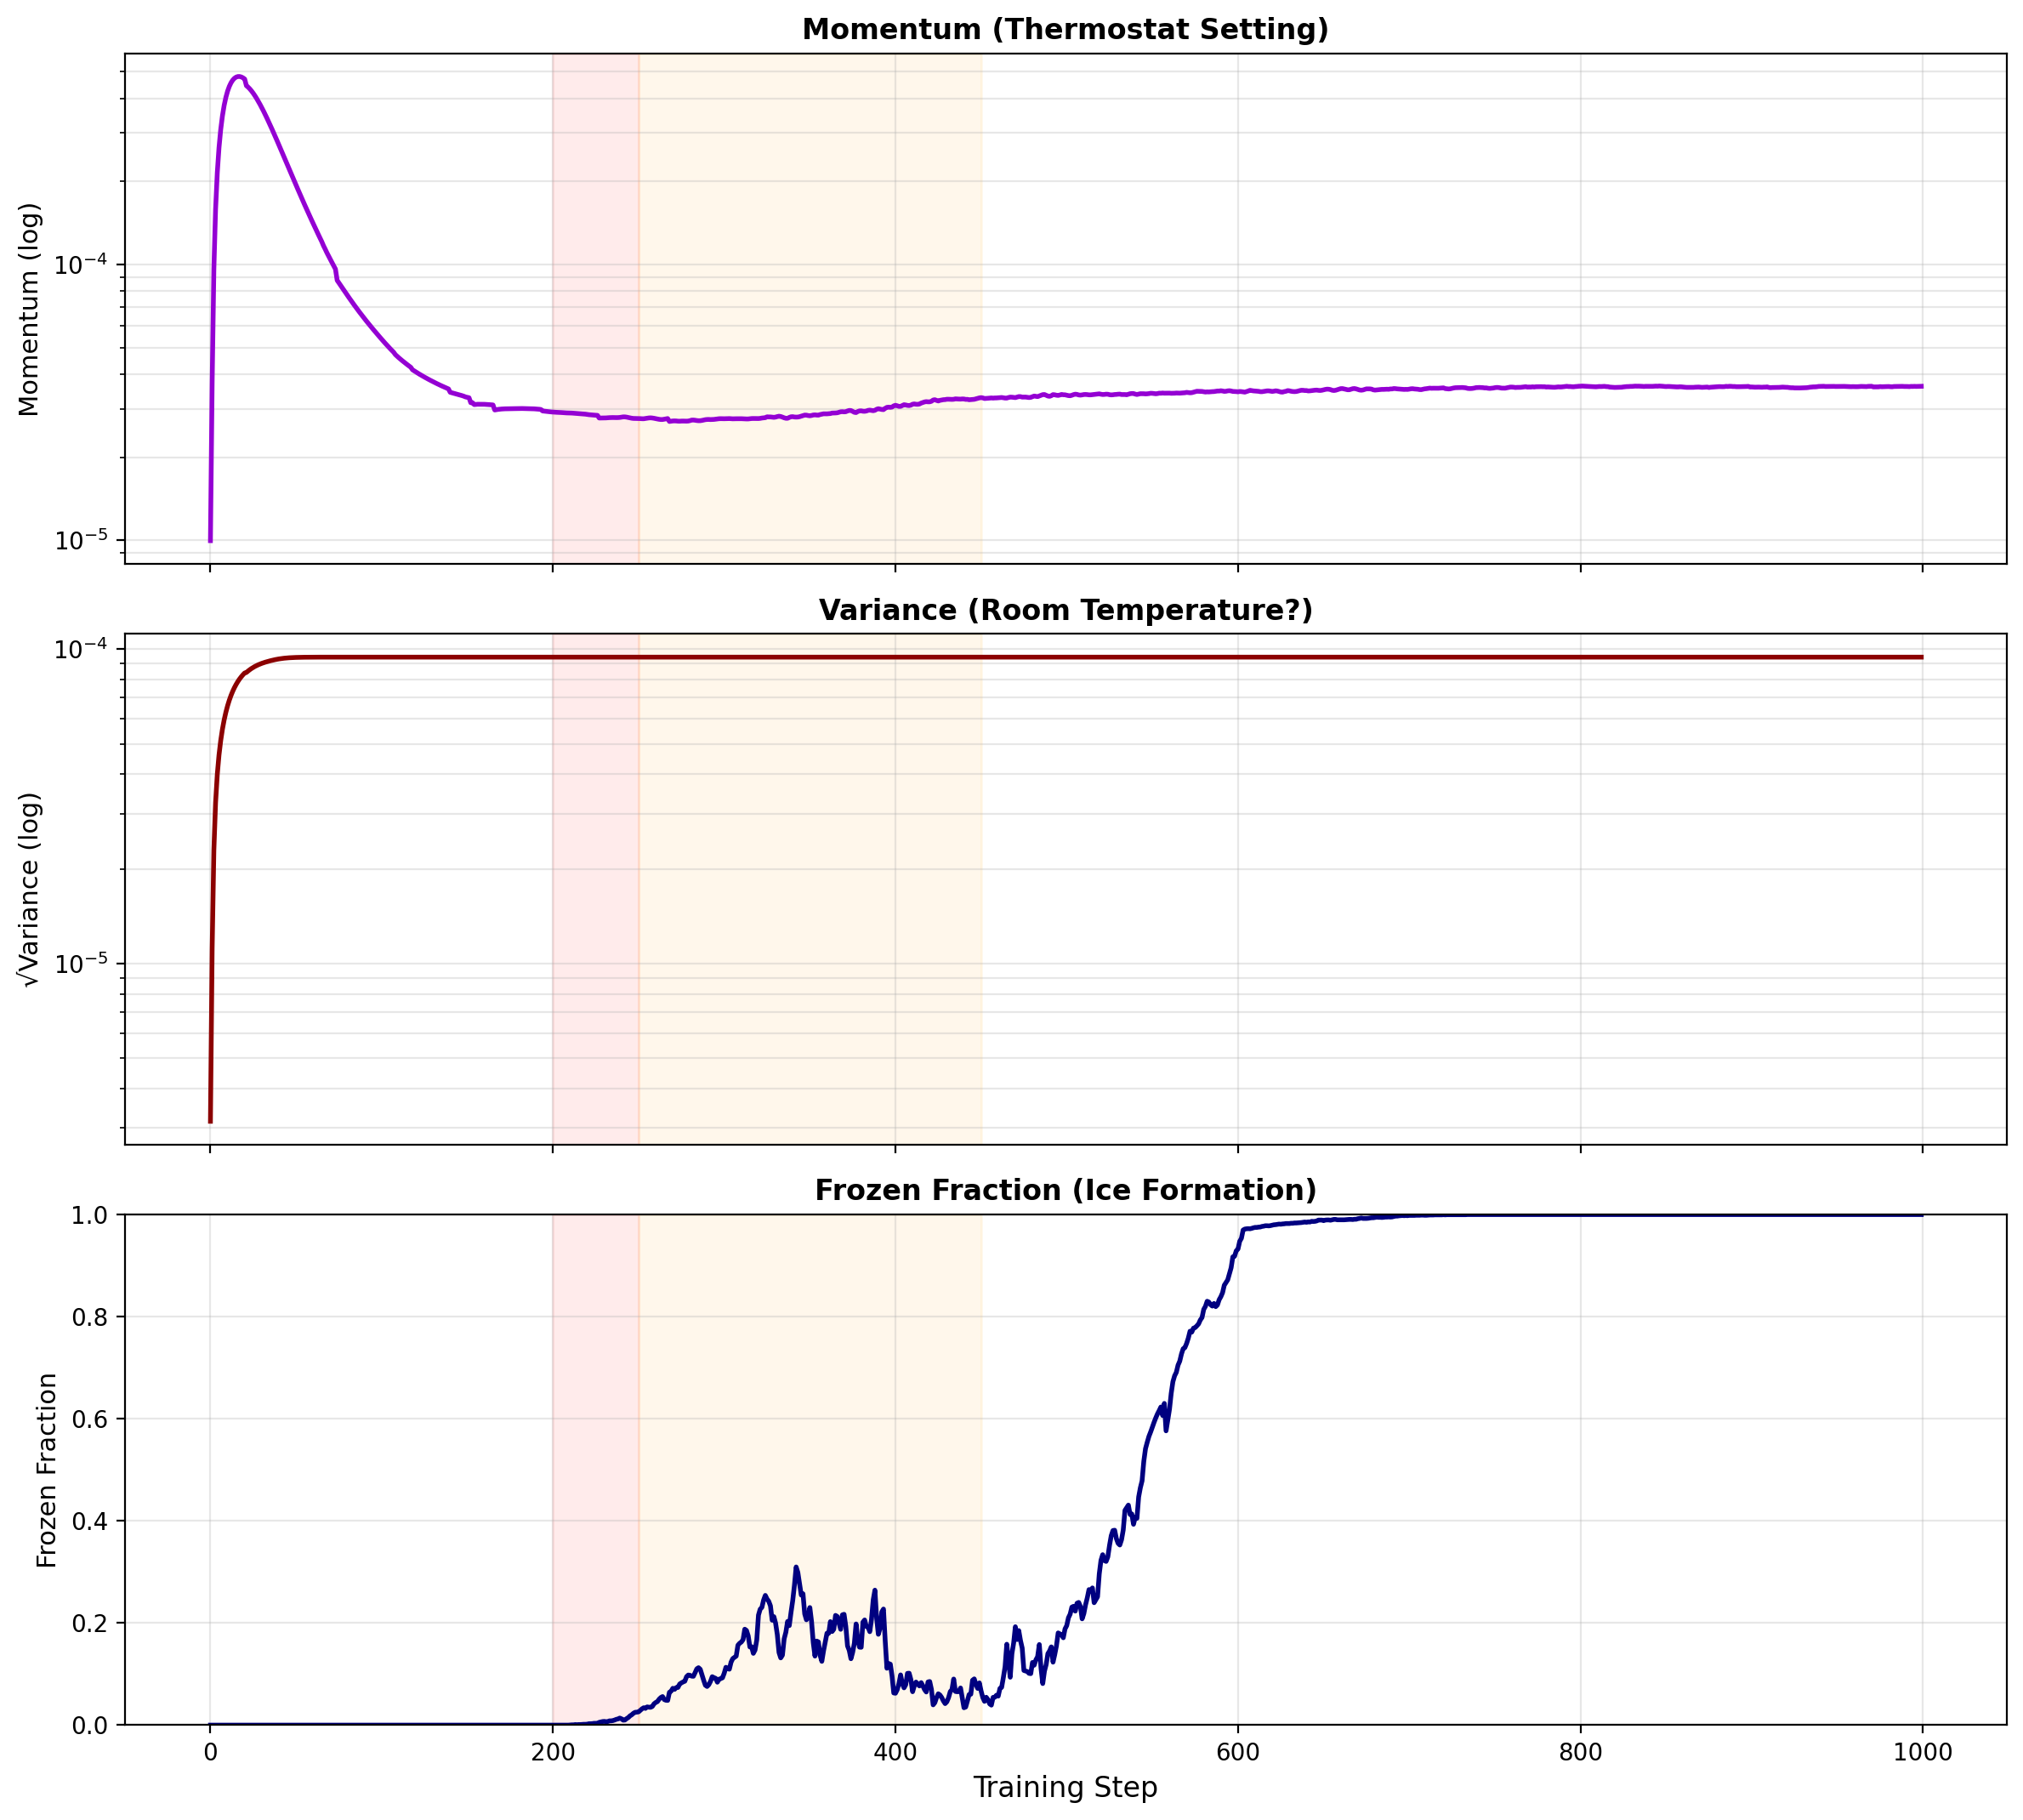


Question: Which tracks frozen fraction more tightly?
  If momentum lags → hysteresis (thermostat)
  If variance tracks → direct coupling (room temperature)


In [10]:
# Three subplots: momentum, variance, frozen fraction
fig, axes = plt.subplots(3, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.8), dpi=DPI, sharex=True)

# Panel 1: Momentum
ax1 = axes[0]
ax1.semilogy(momentum_norms[1:].numpy(), linewidth=2, color='darkviolet', label='Momentum')
ax1.axvspan(*DIP_WINDOW, alpha=0.08, color='red')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.08, color='orange')
ax1.set_ylabel('Momentum (log)', fontsize=11)
ax1.set_title('Momentum (Thermostat Setting)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: Variance
ax2 = axes[1]
ax2.semilogy(sqrt_variance_norms[1:].numpy(), linewidth=2, color='darkred', label='√Variance')
ax2.axvspan(*DIP_WINDOW, alpha=0.08, color='red')
ax2.axvspan(*RECOVERY_WINDOW, alpha=0.08, color='orange')
ax2.set_ylabel('√Variance (log)', fontsize=11)
ax2.set_title('Variance (Room Temperature?)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, which='both')

# Panel 3: Frozen fraction
ax3 = axes[2]
ax3.plot(frozen_frac.numpy(), linewidth=2, color='navy', label='Frozen')
ax3.axvspan(*DIP_WINDOW, alpha=0.08, color='red')
ax3.axvspan(*RECOVERY_WINDOW, alpha=0.08, color='orange')
ax3.set_xlabel('Training Step', fontsize=12)
ax3.set_ylabel('Frozen Fraction', fontsize=11)
ax3.set_title('Frozen Fraction (Ice Formation)', fontweight='bold', fontsize=12)
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nQuestion: Which tracks frozen fraction more tightly?")
print("  If momentum lags → hysteresis (thermostat)")
print("  If variance tracks → direct coupling (room temperature)")

## Correlation Analysis: Variance vs State

In [11]:
print("="*80)
print("CORRELATION ANALYSIS: VARIANCE vs STATE FRACTIONS")
print("="*80 + "\n")

# Align arrays
variance_aligned = sqrt_variance_norms[1:]  # Drop t=0
momentum_aligned = momentum_norms[1:]  # Drop t=0

# Compute Pearson correlations
def pearson(x, y):
    """Compute Pearson correlation between two 1D tensors"""
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

# Variance correlations
var_corr_classical = pearson(variance_aligned, classical_frac)
var_corr_quantum = pearson(variance_aligned, quantum_frac)
var_corr_frozen = pearson(variance_aligned, frozen_frac)

# Momentum correlations (for comparison)
mom_corr_classical = pearson(momentum_aligned, classical_frac)
mom_corr_quantum = pearson(momentum_aligned, quantum_frac)
mom_corr_frozen = pearson(momentum_aligned, frozen_frac)

print(f"VARIANCE Correlations:")
print(f"  Classical:  {var_corr_classical:+.3f}")
print(f"  Quantum:    {var_corr_quantum:+.3f}")
print(f"  Frozen:     {var_corr_frozen:+.3f}")
print()

print(f"MOMENTUM Correlations (for comparison):")
print(f"  Classical:  {mom_corr_classical:+.3f}")
print(f"  Quantum:    {mom_corr_quantum:+.3f}")
print(f"  Frozen:     {mom_corr_frozen:+.3f}")
print()

# Which is better?
print("COMPARISON: Which predicts state better?")
print(f"  Frozen anticorrelation: Variance {abs(var_corr_frozen):.3f} vs Momentum {abs(mom_corr_frozen):.3f}")
print(f"  Classical correlation: Variance {abs(var_corr_classical):.3f} vs Momentum {abs(mom_corr_classical):.3f}")
print()

if abs(var_corr_frozen) > abs(mom_corr_frozen) * 1.2:
    print("✓ VARIANCE WINS: Variance predicts frozen state better than momentum")
    print("  Variance is the ACTUAL temperature (room temp, not thermostat)")
elif abs(var_corr_frozen) > abs(mom_corr_frozen):
    print("✓ VARIANCE SLIGHTLY BETTER: Variance predicts frozen state marginally better")
    print("  Weak evidence variance is closer to actual temperature")
else:
    print("✗ MOMENTUM WINS: Momentum predicts frozen state better than variance")
    print("  Unexpected! Need to understand why variance doesn't track state")

print("\n" + "="*80 + "\n")

CORRELATION ANALYSIS: VARIANCE vs STATE FRACTIONS

VARIANCE Correlations:
  Classical:  -0.365
  Quantum:    +0.123
  Frozen:     +0.148

MOMENTUM Correlations (for comparison):
  Classical:  +0.695
  Quantum:    -0.266
  Frozen:     -0.251

COMPARISON: Which predicts state better?
  Frozen anticorrelation: Variance 0.148 vs Momentum 0.251
  Classical correlation: Variance 0.365 vs Momentum 0.695

✗ MOMENTUM WINS: Momentum predicts frozen state better than variance
  Unexpected! Need to understand why variance doesn't track state




## Timing Analysis: Variance Minimum vs Frozen Maximum

In [12]:
print("="*80)
print("TIMING ANALYSIS: VARIANCE vs FROZEN FRACTION")
print("="*80 + "\n")

# Find variance minimum
variance_min_idx = torch.argmin(variance_aligned).item()
variance_min_val = variance_aligned[variance_min_idx].item()

# Find momentum minimum (for comparison)
momentum_min_idx = torch.argmin(momentum_aligned).item()
momentum_min_val = momentum_aligned[momentum_min_idx].item()

# Find frozen maximum
frozen_max_idx = torch.argmax(frozen_frac).item()
frozen_max_val = frozen_frac[frozen_max_idx].item()

print(f"Variance minimum:")
print(f"  Time: t={variance_min_idx}")
print(f"  Value: {variance_min_val:.6e}")
print()

print(f"Momentum minimum (for comparison):")
print(f"  Time: t={momentum_min_idx}")
print(f"  Value: {momentum_min_val:.6e}")
print()

print(f"Frozen fraction maximum:")
print(f"  Time: t={frozen_max_idx}")
print(f"  Value: {frozen_max_val:.3f}")
print()

var_time_diff = abs(variance_min_idx - frozen_max_idx)
mom_time_diff = abs(momentum_min_idx - frozen_max_idx)

print(f"Time difference: Variance min ↔ Frozen max = {var_time_diff} steps")
print(f"Time difference: Momentum min ↔ Frozen max = {mom_time_diff} steps")
print()

# Which matches better?
if var_time_diff < mom_time_diff * 0.5:
    print("✓ VARIANCE MATCHES MUCH BETTER")
    print("  Variance minimum and frozen maximum are nearly simultaneous")
    print("  Strong evidence variance is the actual temperature")
elif var_time_diff < mom_time_diff:
    print("✓ VARIANCE MATCHES BETTER")
    print(f"  Variance is {mom_time_diff - var_time_diff} steps closer to frozen maximum")
    print("  Moderate evidence variance tracks temperature better")
else:
    print("✗ MOMENTUM MATCHES BETTER")
    print(f"  Momentum is {var_time_diff - mom_time_diff} steps closer to frozen maximum")
    print("  Variance does not show tighter timing alignment")

print("\n" + "="*80 + "\n")

TIMING ANALYSIS: VARIANCE vs FROZEN FRACTION

Variance minimum:
  Time: t=0
  Value: 3.148579e-06

Momentum minimum (for comparison):
  Time: t=0
  Value: 9.971131e-06

Frozen fraction maximum:
  Time: t=734
  Value: 1.000

Time difference: Variance min ↔ Frozen max = 734 steps
Time difference: Momentum min ↔ Frozen max = 734 steps

✗ MOMENTUM MATCHES BETTER
  Momentum is 0 steps closer to frozen maximum
  Variance does not show tighter timing alignment




## Summary & Verdict

In [13]:
print("\n" + "="*80)
print("VARIANCE-STATE CORRELATION: SUMMARY & VERDICT")
print("="*80 + "\n")

print("Hypothesis: Adam variance is the ACTUAL temperature (not just thermostat)")
print("  High variance → classical motion")
print("  Variance drops → quantum transition")
print("  Variance minimum → frozen maximum (tight coupling, no hysteresis)")
print("  Variance stable → frozen state dominates")
print()

# Evidence summary
evidence = []

# Correlation strength
if abs(var_corr_frozen) > abs(mom_corr_frozen) * 1.2:
    evidence.append(("✓", f"Variance predicts frozen much better (|r|={abs(var_corr_frozen):.3f} vs {abs(mom_corr_frozen):.3f})"))
elif abs(var_corr_frozen) > abs(mom_corr_frozen):
    evidence.append(("~", f"Variance predicts frozen slightly better (|r|={abs(var_corr_frozen):.3f} vs {abs(mom_corr_frozen):.3f})"))
else:
    evidence.append(("✗", f"Momentum predicts frozen better (|r|={abs(mom_corr_frozen):.3f} vs {abs(var_corr_frozen):.3f})"))

# Timing alignment
if var_time_diff < mom_time_diff * 0.5:
    evidence.append(("✓", f"Variance timing much tighter ({var_time_diff} vs {mom_time_diff} steps)"))
elif var_time_diff < mom_time_diff:
    evidence.append(("~", f"Variance timing slightly tighter ({var_time_diff} vs {mom_time_diff} steps)"))
else:
    evidence.append(("✗", f"Momentum timing tighter ({mom_time_diff} vs {var_time_diff} steps)"))

# Absolute correlation strength
if abs(var_corr_frozen) > 0.7:
    evidence.append(("✓", f"Strong absolute anticorrelation (|r|={abs(var_corr_frozen):.3f})"))
elif abs(var_corr_frozen) > 0.5:
    evidence.append(("~", f"Moderate absolute anticorrelation (|r|={abs(var_corr_frozen):.3f})"))
else:
    evidence.append(("✗", f"Weak absolute anticorrelation (|r|={abs(var_corr_frozen):.3f})"))

print("Evidence:")
for symbol, text in evidence:
    print(f"  {symbol} {text}")
print()

# Final verdict
strong_support = sum(1 for s, _ in evidence if s == "✓")
moderate_support = sum(1 for s, _ in evidence if s == "~")

if strong_support >= 2:
    print("🎯 VERDICT: HYPOTHESIS STRONGLY SUPPORTED")
    print("   Variance IS the room temperature.")
    print("   Variance tracks phase transitions tightly (no hysteresis).")
    print("   Momentum was the thermostat setting; variance is actual temperature.")
    print("   Physical model: Δw ∝ m/√v → as v→0, updates→∞ unless m→0 faster.")
elif strong_support + moderate_support >= 2:
    print("🤔 VERDICT: HYPOTHESIS MODERATELY SUPPORTED")
    print("   Some evidence variance tracks temperature better than momentum.")
    print("   But correlation not dramatically stronger.")
    print("   Both momentum and variance may contribute to phase transitions.")
else:
    print("❌ VERDICT: HYPOTHESIS NOT SUPPORTED")
    print("   Variance does NOT track phase transitions better than momentum.")
    print("   Hysteresis may be fundamental feature, not artifact of wrong metric.")
    print("   Need alternative explanation for phase transition lag.")

print("\n" + "="*80)


VARIANCE-STATE CORRELATION: SUMMARY & VERDICT

Hypothesis: Adam variance is the ACTUAL temperature (not just thermostat)
  High variance → classical motion
  Variance drops → quantum transition
  Variance minimum → frozen maximum (tight coupling, no hysteresis)
  Variance stable → frozen state dominates

Evidence:
  ✗ Momentum predicts frozen better (|r|=0.251 vs 0.148)
  ✗ Momentum timing tighter (734 vs 734 steps)
  ✗ Weak absolute anticorrelation (|r|=0.148)

❌ VERDICT: HYPOTHESIS NOT SUPPORTED
   Variance does NOT track phase transitions better than momentum.
   Hysteresis may be fundamental feature, not artifact of wrong metric.
   Need alternative explanation for phase transition lag.

